# Notes, Links, Code Snippets During Common Crawl Data Processing

In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import csv
import matplotlib.pyplot as plt
%matplotlib inline

### Links

Example Repo: https://github.com/commoncrawl/cc-pyspark

Common Crawl Format Example: https://gist.github.com/Smerity/e750f0ef0ab9aa366558#file-bbc-warc

Implementing a Search Engine with Ranking in Python: http://aakashjapi.com/fuckin-search-engines-how-do-they-work/


### Scripts

In [ ]:
# run extract_keyword.py in shell
$ cd data/ad-free-search-engine
$ python extract_keyword.py input/test_wat.txt output

# activate vertual environment    
$ cd data/ad-free-search-engine/
$ . venv/bin/activate
$ deactivate 

# Point the environment variable SPARK_HOME to your Spark installation
$ export SPARK_HOME="/Users/lxu213/spark/"

# submit example job to spark
$ $SPARK_HOME/bin/spark-submit ./server_count.py \ --num_output_partitions 1 --log_level WARN \ ./input/test_warc.txt servernames

# readWARC: assuming that you have the aws command line tools installed, you can list the contents of a crawl using:
$ aws s3 ls s3://commoncrawl/crawl-data/CC-MAIN-2014-10/ --recursive | head -6
    
# copy one segment to local using:
$ aws s3 cp s3://commoncrawl/crawl-data/CC-MAIN-2014-10/segments/1394023864559/warc/CC-MAIN-20140305125104-00002-ip-10-183-142-35.ec2.internal.warc.gz .

### Extract Keywords Python Function

Inherits from `CCSparkJob` and can run locally. # total number of records in warc.gz = 138,865

In [ ]:
# extract keywords
kw_path = '/Users/lxu213/data/ad-free-search-engine/spark-warehouse/output_features/part-00000-34ccb7a1-4cbe-413d-bb91-165ea931b1f8-c000.snappy.parquet'
data = pq.read_table(kw_path, nthreads=4).to_pandas()
data['section'].unique()

trips_wkd_rain = trips.loc[(trips['DoW'].isin([5,6])) & trips['PRCP'] != 0] 
data[['url', 'description']].loc[data['keywords'].isin(query.split(' '))] 
data[['url', 'description']].loc[data['keywords'].isin(['lily','cyrus'])] 
kw_data = data[['url', 'title', 'description']].loc[data['keywords'] == 'cities'][:10]
data['url'].loc[data['keywords'] == 'cities']

for index, row in data[:10].iterrows():
    print row['keywords']
    
val = warc['val'] 
url = []
for i in range(len(val)):
    url.append(val[i]['url']) 
    
data['description'].unique()
# with adwords in links
data.describe()
# without adwords in links > removed about 25% of web pages
data_adfree.describe()

# Percent of crawled web pages that contain (detected) ad links:   # 26%
100 - (100*data_adfree.count()['url']/data.count()['url'])

### Rank by tf-idf

In [160]:
# Process WARC
PQPATH='/Users/lxu213/data/ad-free-search-engine/spark-warehouse/add_count/part-00000-6d70eeb9-5f8f-450b-ad70-f431c336e72d-c000.snappy.parquet'
warc = pq.read_table(PQPATH, nthreads=4).to_pandas()
# pq.ParquetFile(PQPATH).metadata

In [161]:
warc['tf-idf'] = pd.Series(0, index=warc.index)
tot_doc = len(warc)/10       # total documents

for i in range(len(warc)):
    docs_w_term = len(warc.loc[warc['keywords'] == warc['keywords'][i]])
    warc.loc[i,'tf-idf'] = warc['val'][i]['count'] * np.log(tot_doc/docs_w_term)

In [188]:
# pyarrow and fastparquet cannot handle nested dict in list
warc = warc.rename(columns={'keywords': 'keywords', 'val': 'val', 'tf-idf': 'tf-idf'})
type(warc.columns[0])
warc.to_parquet(output_path, engine='fastparquet', compression='snappy')

# check if kw_data[50] is dict not string
PQPATH='/Users/lxu213/data/ad-free-search-engine/spark-warehouse/add_count/tf_idf.parquet'
new = pq.read_table(PQPATH, nthreads=4).to_pandas()
kw_data = new['val'].loc[new['keywords'].isin(['dog'])]
type(kw_data[50])

from fastparquet import write
output_path = '/Users/lxu213/data/ad-free-search-engine/spark-warehouse/add_count/tf_idf.parquet'
write(output_path, warc, file_scheme)

new.loc[new['keywords'] == 'dog'].sort_values('tf-idf', ascending=False)

# turns out json.loads can convert string to dict
import json
kw_dict = []
for row in kw_data:
    kw_dict.append(json.loads(row))
    
for i in range(len(warc)):
    docs_w_term = len(warc.loc[warc['keywords'] == warc['keywords'][i]])
    warc.loc[i,'tf-idf'] = warc['val'][i]['count'] * np.log(tot_doc/docs_w_term)
    
idf_dict = {}
for term in set(warc['keywords'][:10]):
    idf_dict[term] = len(warc.loc[warc['keywords'] == term])
    
tot_doc = len(warc)/10       # total documents

for idx, keyword in enumerate(warc['keywords'][:10]):
    print 'tf', warc['val'][idx]['count']
    print 'idf', idf_dict.get(keyword,1.0)
    print 'tf-idf', warc['val'][idx]['count'] * idf_dict.get('keyword',1.0)        

str

### Ad Analysis

In [ ]:
for w in sorted(adwords_dict, key=adwords_dict.get, reverse=True)[:10]:
      print w, adwords_dict[w]

In [2]:
adwords_dict = {}
for key, val in csv.reader(open('ad_analysis_results.csv')):
    adwords_dict[key] = val
    
adwords = pd.DataFrame(list(adwords_dict.iteritems()),
                      columns=['adword','count'], dtype=np.int8)

In [ ]:
for idx, word in enumerate(common_adwords['adword']):
    print idx
    print word[:15]

In [57]:
common_adwords['display_adword'].loc[common_adwords.index == 5]

Series([], Name: display_adword, dtype: object)

In [58]:
common_adwords['display_adword'] = ''

for i in common_adwords['adword']:
    common_adwords['display_adword'].loc[common_adwords.index == idx] = word[:15]

/Users/lxu213/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [59]:
common_adwords

,adword,count,display_adword
11480,/afr?auid=,111,
20770,/afr.php?,91,
7427,/adshow.,90,
13756,?adzone=,90,
6841,/delivery/afr.,82,
14730,&ad_type=,80,
25,.php?zoneid=,80,
3830,http://syndication.exoclick.com/,77,
4329,_ad_slot=,57,
22338,/show_ads.js,53,


KeyError: 'display_adword'

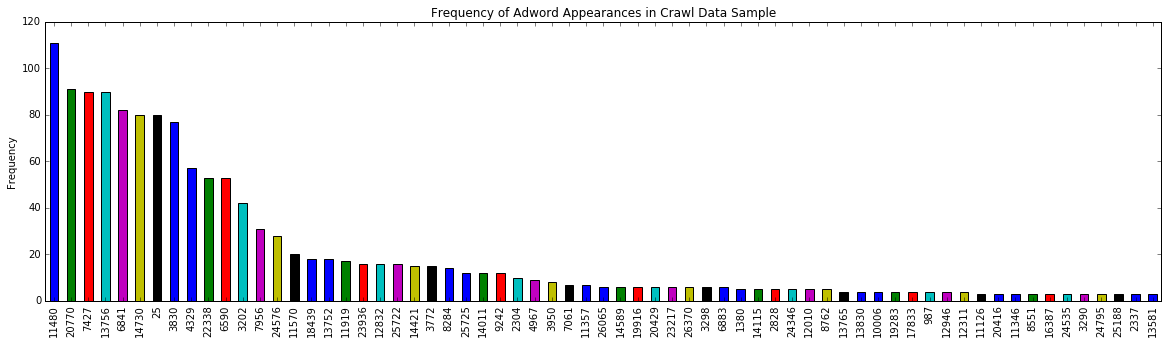

In [39]:
common_adwords = adwords.loc[adwords['count'] > 2].sort_values('count', ascending=False)

plt.figure(figsize=(20,5))
ax = plt.gca()
common_adwords['count'].plot(kind='bar')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Adword Appearances in Crawl Data Sample')
plt.xticks(range(len(common_adwords['count'])), common_adwords['display_adword'])
plt.xticks(rotation=80);